In [1]:
import json
import re
import os
from pathlib import Path

import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import tifffile
import torch
import torch.nn.functional as T
import torchvision.transforms.functional as TF
import wandb
from torch.utils.data import Dataset, DataLoader
from einops import rearrange
from pytorch_lightning.loggers import WandbLogger
from kmeans_pytorch import kmeans, kmeans_predict

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import mushroom.utils as utils
from mushroom.models.clustering import cluster_embeddings

In [5]:
s0 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/results/s0_50knn.pt')
s1 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/codex_dino/multiplex_dino_v2_p8x8_res1.0/results/s1_20knn.pt')
s2 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/codex_dino/multiplex_dino_v2_p8x8_res1.0/results/s2_20knn.pt')
s3 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/metagene_dino_v2/results/s3_50knn.pt')
s4 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/codex_dino/multiplex_dino_v2_p8x8_res1.0/results/s4_20knn.pt')
s5 = torch.load('/data/estorrs/DINO-extended/data/runs/HT397B1/codex_dino/multiplex_dino_v2_p8x8_res1.0/results/s5_20knn.pt')
for k, v in s0.items():
    print(k, v.shape)
    

clustered_patches torch.Size([192, 188])
patch_centroids torch.Size([50, 1024])
patch_embs torch.Size([1024, 192, 188])


In [6]:
slices = [s0, s1, s2, s3, s4, s5]

In [53]:
for s in slices:
    print(s['patch_embs'].shape)

torch.Size([1024, 192, 188])
torch.Size([1024, 484, 480])
torch.Size([1024, 484, 480])
torch.Size([1024, 192, 188])
torch.Size([1024, 484, 480])
torch.Size([1024, 484, 480])


In [54]:
target_size = (484, 480)

In [20]:
import uuid
def get_cluster_image(x, n_clusters, n_samples, tol=10., device='cuda:0'):
    h = x.shape[-2]
    embs = rearrange(x, 'd h w -> (h w) d')
    embs -= embs.mean()
    embs /= embs.std()
    labeled_slices.append({})

    small = embs[np.random.choice(np.arange(embs.shape[0]), size=n_samples)]
    _, cluster_centers = kmeans(
        X=small,
        num_clusters=n_clusters, tol=10., distance='euclidean',
        device='cuda:0'
    )

    cluster_ids_x = kmeans_predict(embs, cluster_centers, device='cuda:0')

    labeled = rearrange(cluster_ids_x, '(ph pw) -> ph pw', ph=h)
    return labeled

def cluster_wrapper(patch_embs, n_clusters, n_samples, tol=10., device='cuda:0'):
    identifier = str(uuid.uuid4())
    print(f'starting {n_clusters} clusters: {identifier}')
    result = get_cluster_image(patch_embs, n_clusters, n_samples, tol=tol, device=device)
    print(f'finished {identifier}')

In [41]:
!pip freeze | egrep 'kmeans'

kmeans-pytorch==0.3


In [42]:
from functools import partial

import numpy as np
import torch
from tqdm import tqdm

from kmeans_pytorch import initialize, pairwise_cosine, pairwise_distance

def kmeans(
        X,
        num_clusters,
        distance='euclidean',
        cluster_centers=[],
        tol=1e-4,
        tqdm_flag=True,
        iter_limit=0,
        device=torch.device('cpu'),
        gamma_for_soft_dtw=0.001,
        seed=None,
):
    """
    perform kmeans
    :param X: (torch.tensor) matrix
    :param num_clusters: (int) number of clusters
    :param distance: (str) distance [options: 'euclidean', 'cosine'] [default: 'euclidean']
    :param seed: (int) seed for kmeans
    :param tol: (float) threshold [default: 0.0001]
    :param device: (torch.device) device [default: cpu]
    :param tqdm_flag: Allows to turn logs on and off
    :param iter_limit: hard limit for max number of iterations
    :param gamma_for_soft_dtw: approaches to (hard) DTW as gamma -> 0
    :return: (torch.tensor, torch.tensor) cluster ids, cluster centers
    """
    if tqdm_flag:
        print(f'running k-means on {device}..')

    pairwise_distance_function = partial(pairwise_distance, device=device)

    # convert to float
    X = X.float()

    # transfer to device
    X = X.to(device)

    # initialize
    if type(cluster_centers) == list:  # ToDo: make this less annoyingly weird
        initial_state = initialize(X, num_clusters)
    else:
        if tqdm_flag:
            print('resuming')
        # find data point closest to the initial cluster center
        initial_state = cluster_centers
        dis = pairwise_distance_function(X, initial_state)
        choice_points = torch.argmin(dis, dim=0)
        initial_state = X[choice_points]
        initial_state = initial_state.to(device)

    iteration = 0
    if tqdm_flag:
        tqdm_meter = tqdm(desc='[running kmeans]')
        
    is_nan = True
    while is_nan:
        print('starting kmeans')
        while True:
            dis = pairwise_distance_function(X, initial_state)

            choice_cluster = torch.argmin(dis, dim=1)

            initial_state_pre = initial_state.clone()

            for index in range(num_clusters):
                selected = torch.nonzero(choice_cluster == index).squeeze().to(device)

                selected = torch.index_select(X, 0, selected)

                # https://github.com/subhadarship/kmeans_pytorch/issues/16
                if selected.shape[0] == 0:
                    selected = X[torch.randint(len(X), (1,))]

                initial_state[index] = selected.mean(dim=0)

            center_shift = torch.sum(
                torch.sqrt(
                    torch.sum((initial_state - initial_state_pre) ** 2, dim=1)
                ))
            
            if torch.isnan(center_shift):
                print('center shift is nan, restarting')
                break

            # increment iteration
            iteration = iteration + 1

            # update tqdm meter
            if tqdm_flag:
                tqdm_meter.set_postfix(
                    iteration=f'{iteration}',
                    center_shift=f'{center_shift ** 2:0.6f}',
                    tol=f'{tol:0.6f}'
                )
                tqdm_meter.update()
            if center_shift ** 2 < tol:
                is_nan = False
                break
            if iter_limit != 0 and iteration >= iter_limit:
                is_nan = False
                break

    return choice_cluster.cpu(), initial_state.cpu()

In [43]:
labeled_slices = []
n_clusters = [20, 40]
n_samples = 10000
for i, s in enumerate(slices):
    h = s['patch_embs'].shape[-2]
    embs = rearrange(s['patch_embs'], 'd h w -> (h w) d')
    embs -= embs.mean()
    embs /= embs.std()
    labeled_slices.append({})
    for n in n_clusters:
        print(i, n)
        small = embs[np.random.choice(np.arange(embs.shape[0]), size=n_samples)]
        _, cluster_centers = kmeans(
            X=small,
            num_clusters=n, tol=10., distance='euclidean',
            device='cuda:0'
        )

        cluster_ids_x = kmeans_predict(embs, cluster_centers, device='cuda:0')

        labeled = rearrange(cluster_ids_x, '(ph pw) -> ph pw', ph=h)
        labeled_slices[i][n] = labeled


0 20
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=3606.509033, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 44.64it/s, center_shift=576.024475, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 60.48it/s, center_shift=133.984314, iteration=3, tol=10.000000]
[running kmeans]: 3it [00:00, 68.70it/s, center_shift=95.850037, iteration=4, tol=10.000000] 
[running kmeans]: 4it [00:00, 73.77it/s, center_shift=76.312134, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 77.14it/s, center_shift=82.523903, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 79.62it/s, center_shift=46.367638, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 81.35it/s, center_shift=25.274023, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 82.99it/s, center_shift=35.565754, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 84.20it/s, center_shift=27.123350, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00,

starting kmeans
predicting on cuda:0..


0 40
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=6137.510254, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 24.55it/s, center_shift=739.603149, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 33.41it/s, center_shift=360.368317, iteration=3, tol=10.000000]
[running kmeans]: 3it [00:00, 38.00it/s, center_shift=237.370163, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 40.79it/s, center_shift=200.190155, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 42.68it/s, center_shift=188.082611, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 50.87it/s, center_shift=188.082611, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 50.87it/s, center_shift=136.611343, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 50.87it/s, center_shift=116.883163, iteration=8, tol=10.000000]

starting kmeans



[running kmeans]: 8it [00:00, 50.87it/s, center_shift=108.341156, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 50.87it/s, center_shift=95.200386, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00, 50.87it/s, center_shift=85.444984, iteration=11, tol=10.000000]
[running kmeans]: 11it [00:00, 50.87it/s, center_shift=66.688858, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 52.95it/s, center_shift=66.688858, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 52.95it/s, center_shift=42.981644, iteration=13, tol=10.000000]
[running kmeans]: 13it [00:00, 52.95it/s, center_shift=33.369816, iteration=14, tol=10.000000]
[running kmeans]: 14it [00:00, 52.95it/s, center_shift=22.749443, iteration=15, tol=10.000000]
[running kmeans]: 15it [00:00, 52.95it/s, center_shift=20.972740, iteration=16, tol=10.000000]
[running kmeans]: 16it [00:00, 52.95it/s, center_shift=12.640292, iteration=17, tol=10.000000]
[running kmeans]: 17it [00:00, 52.95it/s, center_sh

predicting on cuda:0..
1 20
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=25728.109375, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 48.40it/s, center_shift=2583.461182, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 64.08it/s, center_shift=514.233459, iteration=3, tol=10.000000] 
[running kmeans]: 3it [00:00, 71.91it/s, center_shift=270.527802, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 76.55it/s, center_shift=216.325882, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 79.70it/s, center_shift=113.969818, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 81.94it/s, center_shift=66.314705, iteration=7, tol=10.000000] 
[running kmeans]: 7it [00:00, 83.62it/s, center_shift=52.239166, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 84.94it/s, center_shift=40.776321, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 85.97it/s, center_shift=20.651451, iteration=10, tol=10.000000]
[running kmeans]: 10it [

starting kmeans
predicting on cuda:0..


1 40
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=43698.617188, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 27.23it/s, center_shift=2603.609619, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 36.38it/s, center_shift=1421.215332, iteration=3, tol=10.000000]
[running kmeans]: 3it [00:00, 40.99it/s, center_shift=673.168640, iteration=4, tol=10.000000] 
[running kmeans]: 4it [00:00, 43.73it/s, center_shift=445.089783, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 45.60it/s, center_shift=257.529816, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 54.33it/s, center_shift=257.529816, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 54.33it/s, center_shift=175.834915, iteration=7, tol=10.000000]

starting kmeans



[running kmeans]: 7it [00:00, 54.33it/s, center_shift=155.697388, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 54.33it/s, center_shift=140.246185, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 54.33it/s, center_shift=144.224213, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00, 54.33it/s, center_shift=114.754990, iteration=11, tol=10.000000]
[running kmeans]: 11it [00:00, 54.33it/s, center_shift=125.713173, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 54.19it/s, center_shift=125.713173, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 54.19it/s, center_shift=69.862396, iteration=13, tol=10.000000] 
[running kmeans]: 13it [00:00, 54.19it/s, center_shift=60.802948, iteration=14, tol=10.000000]
[running kmeans]: 14it [00:00, 54.19it/s, center_shift=62.229443, iteration=15, tol=10.000000]
[running kmeans]: 15it [00:00, 54.19it/s, center_shift=45.699993, iteration=16, tol=10.000000]
[running kmeans]: 16it [00:00, 54.19it/s, cente

predicting on cuda:0..
2 20
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=14842.324219, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 50.43it/s, center_shift=1902.097046, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 66.86it/s, center_shift=953.745605, iteration=3, tol=10.000000] 
[running kmeans]: 3it [00:00, 75.05it/s, center_shift=278.141174, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 79.92it/s, center_shift=122.877670, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 83.23it/s, center_shift=61.427692, iteration=6, tol=10.000000] 
[running kmeans]: 6it [00:00, 85.54it/s, center_shift=44.779907, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 87.36it/s, center_shift=31.064112, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 88.75it/s, center_shift=21.763489, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 89.85it/s, center_shift=11.953592, iteration=10, tol=10.000000]
[running kmeans]: 10it [0

starting kmeans
predicting on cuda:0..


2 40
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=25418.296875, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 27.63it/s, center_shift=2547.996582, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 36.61it/s, center_shift=940.217346, iteration=3, tol=10.000000] 
[running kmeans]: 3it [00:00, 41.07it/s, center_shift=271.019226, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 43.73it/s, center_shift=142.882004, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 45.51it/s, center_shift=116.071396, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 54.18it/s, center_shift=116.071396, iteration=6, tol=10.000000]

starting kmeans



[running kmeans]: 6it [00:00, 54.18it/s, center_shift=136.598053, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 54.18it/s, center_shift=97.863571, iteration=8, tol=10.000000] 
[running kmeans]: 8it [00:00, 54.18it/s, center_shift=102.006233, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 54.18it/s, center_shift=113.344322, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00, 54.18it/s, center_shift=87.778076, iteration=11, tol=10.000000]
[running kmeans]: 11it [00:00, 54.18it/s, center_shift=103.057655, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 54.70it/s, center_shift=103.057655, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 54.70it/s, center_shift=81.395439, iteration=13, tol=10.000000] 
[running kmeans]: 13it [00:00, 54.70it/s, center_shift=59.927189, iteration=14, tol=10.000000]
[running kmeans]: 14it [00:00, 54.70it/s, center_shift=52.497417, iteration=15, tol=10.000000]
[running kmeans]: 15it [00:00, 54.70it/s, center_

predicting on cuda:0..
3 20
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=2878.665771, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 50.54it/s, center_shift=316.502441, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 66.88it/s, center_shift=118.281517, iteration=3, tol=10.000000]
[running kmeans]: 3it [00:00, 75.06it/s, center_shift=61.405907, iteration=4, tol=10.000000] 
[running kmeans]: 4it [00:00, 79.91it/s, center_shift=44.984589, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 83.20it/s, center_shift=40.138618, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 85.48it/s, center_shift=33.651680, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 87.30it/s, center_shift=25.083788, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 88.66it/s, center_shift=22.288000, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 89.79it/s, center_shift=18.774981, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00,

starting kmeans
predicting on cuda:0..


3 40
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=6821.825684, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 27.59it/s, center_shift=1190.143921, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 36.59it/s, center_shift=577.292542, iteration=3, tol=10.000000] 
[running kmeans]: 3it [00:00, 41.05it/s, center_shift=394.357208, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 43.71it/s, center_shift=197.879562, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 45.49it/s, center_shift=97.632156, iteration=6, tol=10.000000] 
[running kmeans]: 6it [00:00, 54.06it/s, center_shift=97.632156, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 54.06it/s, center_shift=75.875816, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 54.06it/s, center_shift=58.128330, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 54.06it/s, center_shift=27.950390, iteration=9, tol=10.000000]

starting kmeans



[running kmeans]: 9it [00:00, 54.06it/s, center_shift=24.100964, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00, 54.06it/s, center_shift=42.699013, iteration=11, tol=10.000000]
[running kmeans]: 11it [00:00, 54.06it/s, center_shift=35.602837, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 53.98it/s, center_shift=35.602837, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 53.98it/s, center_shift=52.126736, iteration=13, tol=10.000000]
[running kmeans]: 13it [00:00, 53.98it/s, center_shift=51.193531, iteration=14, tol=10.000000]
[running kmeans]: 14it [00:00, 53.98it/s, center_shift=32.765934, iteration=15, tol=10.000000]
[running kmeans]: 15it [00:00, 53.98it/s, center_shift=13.428413, iteration=16, tol=10.000000]
[running kmeans]: 16it [00:00, 53.98it/s, center_shift=19.314051, iteration=17, tol=10.000000]
[running kmeans]: 17it [00:00, 53.98it/s, center_shift=9.781334, iteration=18, tol=10.000000] 
[running kmeans]: 18it [00:00, 53.33it/s, center_s

predicting on cuda:0..
4 20
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=10328.297852, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 50.50it/s, center_shift=884.037537, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 66.71it/s, center_shift=365.047211, iteration=3, tol=10.000000]
[running kmeans]: 3it [00:00, 74.69it/s, center_shift=245.046112, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 79.43it/s, center_shift=241.896591, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 82.61it/s, center_shift=229.040314, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 84.87it/s, center_shift=126.764412, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 86.57it/s, center_shift=69.650696, iteration=8, tol=10.000000] 
[running kmeans]: 8it [00:00, 87.85it/s, center_shift=36.596550, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 88.91it/s, center_shift=28.333502, iteration=10, tol=10.000000]
[running kmeans]: 10it [0

starting kmeans
predicting on cuda:0..


4 40
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=28062.271484, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 27.72it/s, center_shift=1684.859985, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 36.70it/s, center_shift=694.176697, iteration=3, tol=10.000000] 
[running kmeans]: 3it [00:00, 41.15it/s, center_shift=353.621155, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 43.81it/s, center_shift=214.478104, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 45.58it/s, center_shift=156.609314, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 54.28it/s, center_shift=156.609314, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 54.28it/s, center_shift=121.090843, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 54.28it/s, center_shift=101.202896, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 54.28it/s, center_shift=61.763569, iteration=9, tol=10.000000] 

starting kmeans



[running kmeans]: 9it [00:00, 54.28it/s, center_shift=42.940014, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00, 54.28it/s, center_shift=33.595528, iteration=11, tol=10.000000]
[running kmeans]: 11it [00:00, 54.28it/s, center_shift=31.273344, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 53.92it/s, center_shift=31.273344, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 53.92it/s, center_shift=31.749434, iteration=13, tol=10.000000]
[running kmeans]: 13it [00:00, 53.92it/s, center_shift=36.201630, iteration=14, tol=10.000000]
[running kmeans]: 14it [00:00, 53.92it/s, center_shift=37.227943, iteration=15, tol=10.000000]
[running kmeans]: 15it [00:00, 53.92it/s, center_shift=52.985107, iteration=16, tol=10.000000]
[running kmeans]: 16it [00:00, 53.92it/s, center_shift=49.371109, iteration=17, tol=10.000000]
[running kmeans]: 17it [00:00, 53.92it/s, center_shift=42.583710, iteration=18, tol=10.000000]
[running kmeans]: 18it [00:00, 54.04it/s, center_s

predicting on cuda:0..
5 20
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=14960.782227, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 48.39it/s, center_shift=1290.933716, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 63.99it/s, center_shift=323.770569, iteration=3, tol=10.000000] 
[running kmeans]: 3it [00:00, 71.78it/s, center_shift=182.117340, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 76.49it/s, center_shift=129.144836, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 79.51it/s, center_shift=123.011009, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 81.75it/s, center_shift=84.011192, iteration=7, tol=10.000000] 
[running kmeans]: 7it [00:00, 83.36it/s, center_shift=37.039059, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 84.63it/s, center_shift=28.548775, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 85.66it/s, center_shift=18.207869, iteration=10, tol=10.000000]
[running kmeans]: 10it [

starting kmeans



[running kmeans]: 14it [00:00, 94.45it/s, center_shift=14.153609, iteration=15, tol=10.000000]
[running kmeans]: 15it [00:00, 94.45it/s, center_shift=11.478746, iteration=16, tol=10.000000]
[running kmeans]: 16it [00:00, 94.45it/s, center_shift=11.831727, iteration=17, tol=10.000000]
[running kmeans]: 17it [00:00, 94.45it/s, center_shift=12.284362, iteration=18, tol=10.000000]
[running kmeans]: 18it [00:00, 94.45it/s, center_shift=12.411472, iteration=19, tol=10.000000]
[running kmeans]: 19it [00:00, 94.45it/s, center_shift=9.804093, iteration=20, tol=10.000000] 
[running kmeans]: 20it [00:00, 94.87it/s, center_shift=9.804093, iteration=20, tol=10.000000]


predicting on cuda:0..
5 40
running k-means on cuda:0..



[running kmeans]: 0it [00:00, ?it/s]
[running kmeans]: 0it [00:00, ?it/s, center_shift=20156.660156, iteration=1, tol=10.000000]
[running kmeans]: 1it [00:00, 27.72it/s, center_shift=2229.584473, iteration=2, tol=10.000000]
[running kmeans]: 2it [00:00, 36.83it/s, center_shift=789.640137, iteration=3, tol=10.000000] 
[running kmeans]: 3it [00:00, 41.36it/s, center_shift=421.787903, iteration=4, tol=10.000000]
[running kmeans]: 4it [00:00, 44.10it/s, center_shift=285.445099, iteration=5, tol=10.000000]
[running kmeans]: 5it [00:00, 45.92it/s, center_shift=299.160431, iteration=6, tol=10.000000]
[running kmeans]: 6it [00:00, 54.71it/s, center_shift=299.160431, iteration=6, tol=10.000000]

starting kmeans



[running kmeans]: 6it [00:00, 54.71it/s, center_shift=281.255310, iteration=7, tol=10.000000]
[running kmeans]: 7it [00:00, 54.71it/s, center_shift=185.442841, iteration=8, tol=10.000000]
[running kmeans]: 8it [00:00, 54.71it/s, center_shift=150.003159, iteration=9, tol=10.000000]
[running kmeans]: 9it [00:00, 54.71it/s, center_shift=129.808823, iteration=10, tol=10.000000]
[running kmeans]: 10it [00:00, 54.71it/s, center_shift=112.183777, iteration=11, tol=10.000000]
[running kmeans]: 11it [00:00, 54.71it/s, center_shift=88.932152, iteration=12, tol=10.000000] 
[running kmeans]: 12it [00:00, 55.07it/s, center_shift=88.932152, iteration=12, tol=10.000000]
[running kmeans]: 12it [00:00, 55.07it/s, center_shift=59.472206, iteration=13, tol=10.000000]
[running kmeans]: 13it [00:00, 55.07it/s, center_shift=45.405373, iteration=14, tol=10.000000]
[running kmeans]: 14it [00:00, 55.07it/s, center_shift=31.920206, iteration=15, tol=10.000000]
[running kmeans]: 15it [00:00, 55.07it/s, center_s

predicting on cuda:0..


In [62]:
for d in labeled_slices:
    for n, img in d.items():
        x = torch.tensor(img).unsqueeze(0)
        x = TF.resize(x, size=target_size, antialias=False,
                      interpolation=TF.InterpolationMode.NEAREST)
        x = x.squeeze()
        d[n] = x.numpy()

In [63]:
for d in labeled_slices:
    print(d[20].shape)

(484, 480)
(484, 480)
(484, 480)
(484, 480)
(484, 480)
(484, 480)


In [64]:
import seaborn as sns
extended = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')

In [65]:
labeled_slices[0][20]

array([[ 0,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  1,  0,  0],
       [ 0,  0,  0, ...,  1,  0,  0],
       ...,
       [ 1,  1,  1, ..., 14, 14, 14],
       [14, 14, 14, ...,  0,  0,  0],
       [14, 14, 14, ...,  0,  0,  0]])

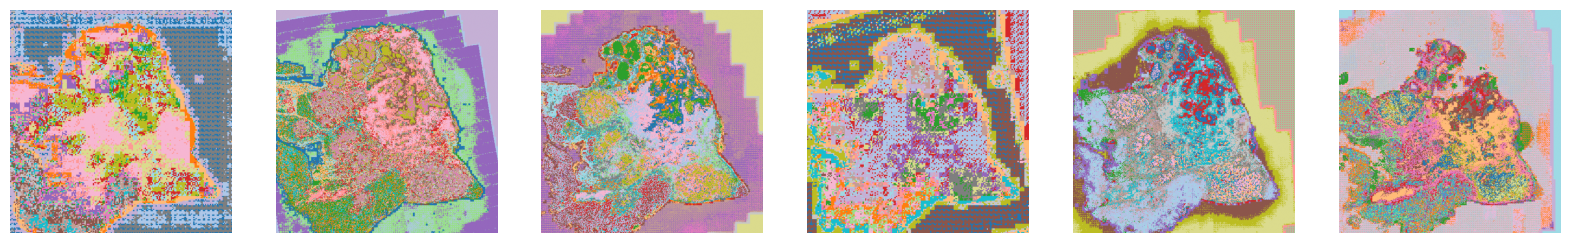

In [66]:
n = 20
fig, axs = plt.subplots(ncols=len(labeled_slices), figsize=(20, 5))
for i, d in enumerate(labeled_slices):
    ax = axs[i]
    rgb = utils.display_labeled_as_rgb(d[n], cmap=extended)
    ax.imshow(rgb)
    ax.axis('off')

[running kmeans]: 0it [19:05, ?it/s]


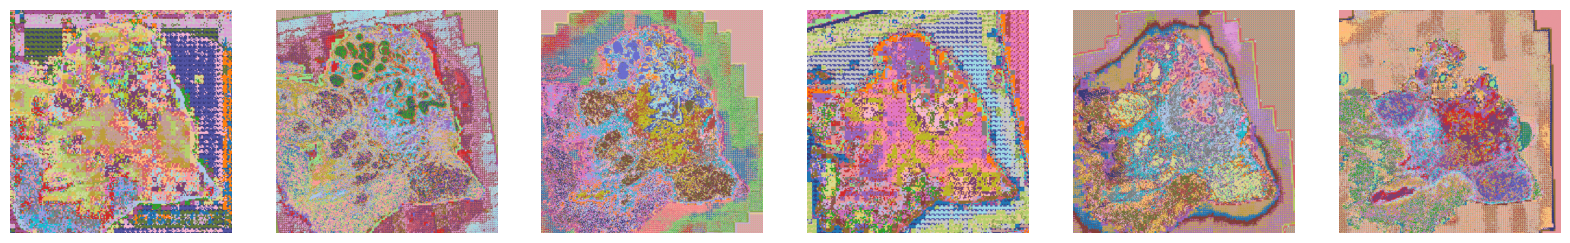

In [67]:
n = 40
fig, axs = plt.subplots(ncols=len(labeled_slices), figsize=(20, 5))
for i, d in enumerate(labeled_slices):
    ax = axs[i]
    rgb = utils.display_labeled_as_rgb(d[n], cmap=extended)
    ax.imshow(rgb)
    ax.axis('off')

In [79]:
from collections import Counter
nc1, nc2 = 20, 40
x1, x2 = labeled_slices[0][nc1], labeled_slices[1][nc2]
tups = [(l1, l2) for l1, l2, in zip(x1.flatten(), x2.flatten())]
counts = Counter(tups)


In [97]:
adj_matrix = pd.DataFrame(data=np.zeros((nc1, nc2)))
for (l1, l2), count in counts.items():
    adj_matrix.iloc[l1, l2] = count
adj_matrix

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.0,0.0,0.0,189.0,0.0,171.0,601.0,12.0,0.0,0.0,...,0.0,2.0,2069.0,1.0,1554.0,0.0,2472.0,887.0,0.0,2551.0
1,5.0,0.0,8.0,185.0,8.0,47.0,137.0,14.0,0.0,7.0,...,2.0,8.0,1091.0,14.0,1381.0,1.0,1775.0,677.0,1.0,1430.0
2,222.0,45.0,147.0,0.0,284.0,1063.0,237.0,557.0,97.0,242.0,...,95.0,202.0,37.0,443.0,37.0,338.0,76.0,7.0,30.0,31.0
3,329.0,21.0,127.0,2.0,139.0,650.0,156.0,666.0,38.0,161.0,...,87.0,220.0,201.0,213.0,63.0,153.0,114.0,37.0,66.0,250.0
4,147.0,369.0,188.0,0.0,410.0,101.0,30.0,173.0,256.0,195.0,...,47.0,89.0,0.0,279.0,1.0,118.0,4.0,2.0,68.0,0.0
5,200.0,25.0,32.0,0.0,55.0,156.0,24.0,309.0,18.0,61.0,...,10.0,143.0,0.0,62.0,9.0,27.0,5.0,0.0,7.0,0.0
6,129.0,472.0,866.0,0.0,998.0,51.0,7.0,170.0,199.0,559.0,...,250.0,51.0,0.0,772.0,2.0,334.0,4.0,0.0,883.0,5.0
7,394.0,478.0,328.0,0.0,245.0,224.0,34.0,518.0,445.0,836.0,...,408.0,133.0,7.0,307.0,2.0,364.0,11.0,1.0,168.0,13.0
8,472.0,408.0,154.0,0.0,403.0,104.0,5.0,550.0,303.0,579.0,...,167.0,187.0,2.0,305.0,0.0,238.0,0.0,1.0,74.0,3.0
9,116.0,0.0,8.0,131.0,73.0,1161.0,1489.0,442.0,0.0,2.0,...,1.0,213.0,735.0,58.0,1175.0,21.0,2227.0,388.0,0.0,1290.0


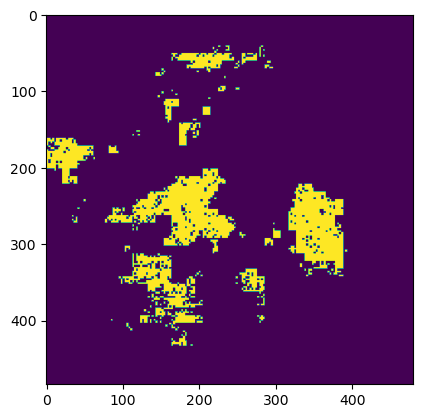

In [100]:
plt.imshow(x1==13)

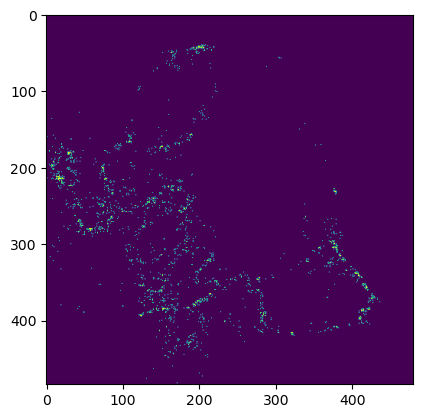

In [101]:
plt.imshow(x2==14)

In [98]:
mapping = adj_matrix.values.argmax(axis=0)
mapping

array([10, 17, 16, 14, 16,  9,  9, 10, 13, 13, 16, 16, 10, 14, 13, 14, 13,
       13, 16, 14, 16, 17,  9, 13, 14, 14, 10, 13, 14, 13, 13, 10, 14, 16,
       14, 13, 14, 14,  6, 14])

In [93]:
x2

array([[13, 13, 13, ..., 13, 13, 24],
       [ 3, 24, 13, ..., 24, 13, 13],
       [13, 13, 24, ..., 13, 24, 24],
       ...,
       [ 3, 25, 25, ..., 15, 37, 37],
       [25, 25, 25, ..., 37, 19, 37],
       [25, 25, 25, ..., 15, 19, 15]])

In [95]:
new = x2.copy()
for old_c, new_c in enumerate(mapping):
    new[x2==old_c] = new_c

In [99]:
new

array([[14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       ...,
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14],
       [14, 14, 14, ..., 14, 14, 14]])

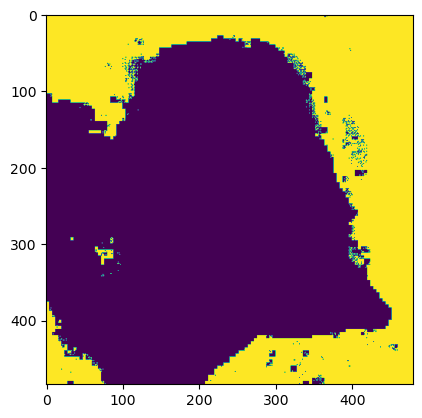

In [102]:
plt.imshow(new==14)

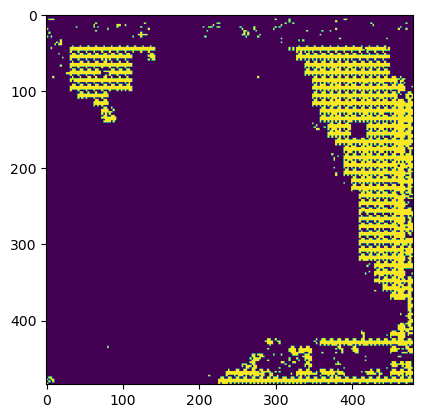

In [103]:
plt.imshow(x1==14)

In [104]:
new[0, :20] = np.arange(20)

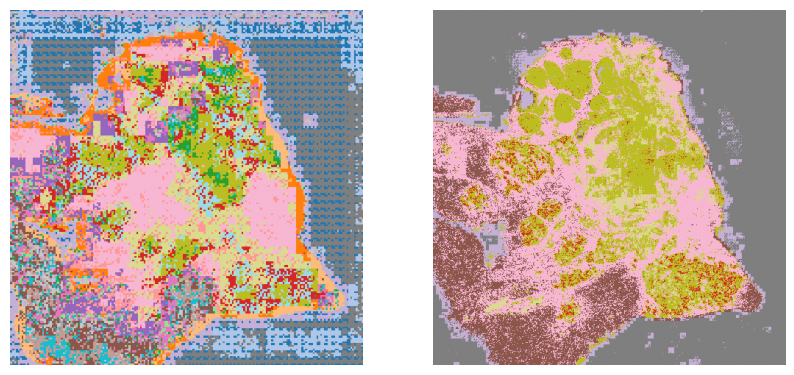

In [105]:
n = 20
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
for i, img in enumerate([x1, new]):
    ax = axs[i]
    rgb = utils.display_labeled_as_rgb(img, cmap=extended)
    ax.imshow(rgb)
    ax.axis('off')

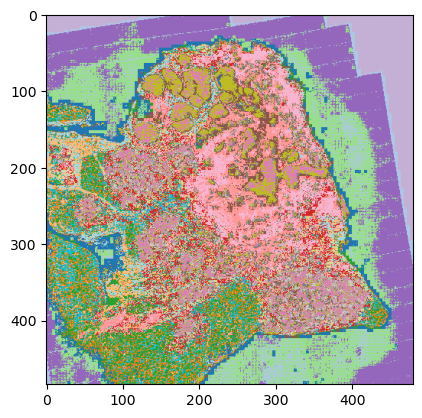

In [108]:
s = labeled_slices[1][20]
rgb = utils.display_labeled_as_rgb(s, cmap=extended)
plt.imshow(rgb)
# plt.axis('off')

(-0.5, 99.5, 99.5, -0.5)

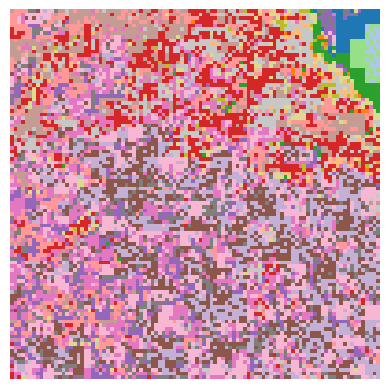

In [111]:
s = labeled_slices[1][20]
rgb = utils.display_labeled_as_rgb(s[300:400, 300:400], cmap=extended)
plt.imshow(rgb)
plt.axis('off')